##### PREPROCESSING

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [34]:
df = pd.read_csv("car data.csv")

In [35]:
df.sample(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
163,Bajaj Avenger 220 dtsi,2010,0.45,0.95,27000,Petrol,Individual,Manual,0
174,Honda CB Unicorn,2015,0.38,0.72,38600,Petrol,Individual,Manual,0
5,vitara brezza,2018,9.25,9.83,2071,Diesel,Dealer,Manual,0
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
132,Bajaj Avenger 220,2017,0.75,0.95,3500,Petrol,Individual,Manual,0


In [36]:
df.shape

(301, 9)

In [37]:
df.isna().values.any() 

False

In [38]:
print("Fuel Type: ", df.Fuel_Type.unique())
print("Seller Type: ", df.Seller_Type.unique())
print("Transmission: ", df.Transmission.unique())
print("Owner: ", df.Owner.unique())

Fuel Type:  ['Petrol' 'Diesel' 'CNG']
Seller Type:  ['Dealer' 'Individual']
Transmission:  ['Manual' 'Automatic']
Owner:  [0 1 3]


In [39]:
from datetime import datetime
df["Current_year"] = datetime.now().year
df["Year"] = df.Current_year - df.Year


In [40]:
#df.drop(columns="Current_year", axis = 1, inplace = True)

### Data visualization

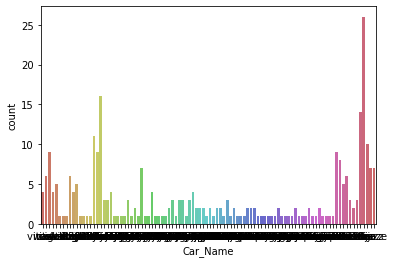

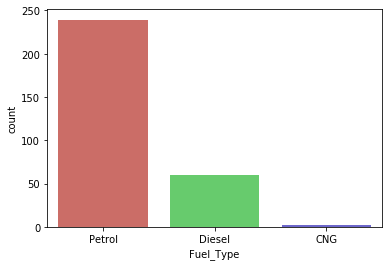

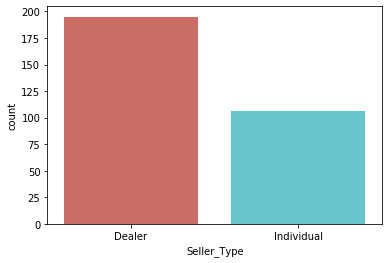

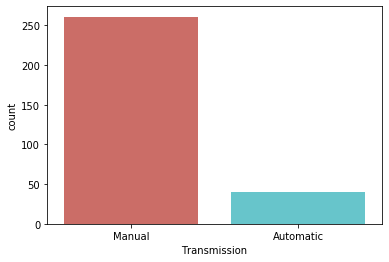

In [42]:
for col in df.select_dtypes("object"):
    plt.figure()
    sns. countplot(df[col],palette='hls')

In [197]:
# ENCODING
dummy = pd.get_dummies(df[["Fuel_Type", "Seller_Type", "Transmission"]], drop_first = True)
df = pd.concat( [df, dummy], axis = 1)
df.drop(columns = ["Fuel_Type", "Seller_Type", "Transmission"], inplace = True)

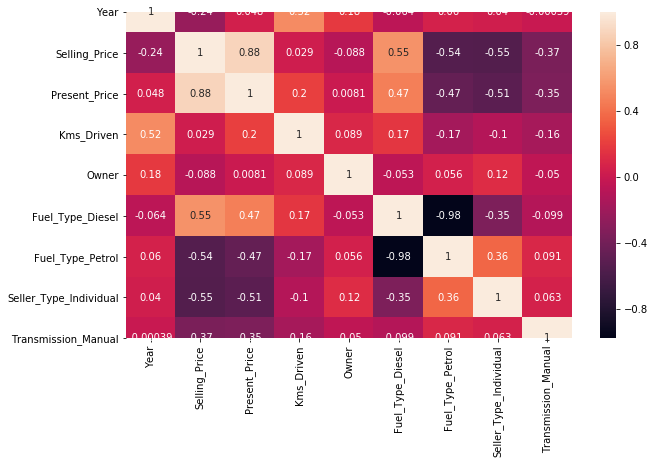

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (10, 6))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [199]:
df.Car_Name = df.Car_Name.str.lower()
dummy = pd.get_dummies(df.Car_Name, drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df.drop("Car_Name", axis = 1, inplace = True)

In [200]:
X = df.drop(columns="Selling_Price")
y = df.Selling_Price

In [201]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor()
etr.fit(X, y)
important_features = etr.feature_importances_

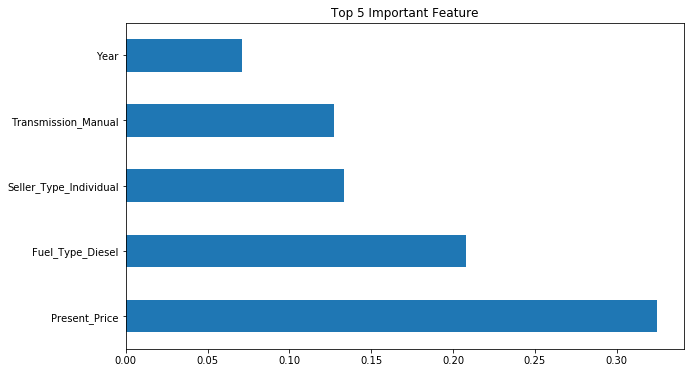

In [202]:
important_features = pd.Series(important_features, index = X.columns).sort_values(ascending = False)
plt.figure(figsize = (10, 6))
important_features[:5].plot(kind = "barh")
plt.title("Top 5 Important Feature")
plt.show()

In [203]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [204]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [205]:
# let's create a dict for paramer


algos = {
    "Linear Regression": {
        "model": LinearRegression(),
        "param":{
            "normalize":[True, False]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "param": {
            "criterion": ["mse", "friedman_mse"],
            "splitter": ["best", "random"]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "param": {
            "n_estimators": [int(x) for x in np.linspace(100, 1200, 12)],
            "max_features": ["auto", "sqrt"],
            "max_depth": [int(x) for x in np.linspace(5, 30, 6)],
            "min_samples_split": [2, 5, 10, 15, 100],
            "min_samples_leaf": [1, 2, 5, 10]
        }
    }
}

In [206]:
# let's find best algotithm with it's best parameter
# here we are going to use Randomize Search cv for hyperparamter tuninig

from sklearn.model_selection import RandomizedSearchCV

best_models = {}
scores = []
for model_name, values in algos.items():
    model_tunning = RandomizedSearchCV(values["model"], values["param"], n_iter=10, cv = 5, n_jobs = -1)
    model_tunning.fit(X_train, y_train)
    
    best_models[model_name] = model_tunning
    scores.append({
        "Model": model_name,
        "Best Parameters": model_tunning.best_params_,
        "Best Score": model_tunning.best_score_
    })
    
pd.DataFrame(scores)

C:\Users\KARTHIK GR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\KARTHIK GR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


,Model,Best Parameters,Best Score
0,Linear Regression,{'normalize': False},0.725426
1,Decision Tree,"{'splitter': 'best', 'criterion': 'friedman_mse'}",0.921461
2,Random Forest,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.892024


In [207]:
# In above we can see that Decision Tree is best algorithm with 92% accuracy
# but let's test all the algorithm on our test data set

for name, model in best_models.items():
    print(name, " : ", model.score(X_test, y_test))


Linear Regression  :  0.5954184978955038
Decision Tree  :  0.950088205249568
Random Forest  :  0.9596688527867206


##### so we can see above when we test those trained model using test data we get random forest is best algorithm with 96% accuracy 

In [208]:
# let's take our final model
final_model = best_models["Random Forest"]

In [209]:
# so here we take Random Forest model for our problem

def predict_price(year, present_price, kms, owner, diesel, petrol, individual, manual, vehicle):
    vehicle_index = np.where(X.columns == vehicle.lower())[0][0]
    X_pred = np.zeros_like(X.columns)
    
    feature_list = [year, present_price, kms, owner, diesel, petrol, individual, manual]
    count = 0
    for f in feature_list:
        X_pred[count] = f
        count += 1
    
    if vehicle_index > 0:
        X_pred[vehicle_index] = 1
    
    result = final_model.predict([X_pred])
    
    return result


In [210]:
predict_price(7, 9.54, 43000, 0, 1, 0, 0, 1, "sx4")

array([6.04246962])

In [211]:
# our model is working perfectly fine with around 96% accuracy
# let's save our model as binary file

import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [212]:
# let's save json file of our columns, it's use in frontend

import json

column_dict = {"data_columns": X.columns.to_list()}

with open("columns.json", "w") as f:
    json.dump(column_dict, f)